# The Plan 

![schema](assets/schema.png)

## Imports

In [1]:
import requests
import math
import pandas as pd
from tqdm.notebook import tqdm
import time
import json
import io

In [2]:
start = 0
end = 50000

## Functions
Query Ensembl <br>
Query Uniprot

In [3]:
# Find all the genes on a chromosome region
def find_genes(chrom, start, end):
    embl = "https://rest.ensembl.org"
    q = "/overlap/region/human/{0}:{1}-{2}?feature=gene"
    re = requests.get(embl+q.format(chrom, start, end),
                  headers={ "Content-Type" : "application/json"})
    
    if not re.ok:        
        re.raise_for_status()
        sys.exit()
    
    return pd.DataFrame.from_records(re.json())

#Find the gene sequences of a list of genes
def get_gene_seqs(gene_list):
    server = "https://rest.ensembl.org"
    ext = "/sequence/id"
    headers={ "Content-Type" : "application/json", "Accept" : "application/json"}
    
    records = []
    #POST has max requst size of 50 objects
    for i in range(math.ceil(len(gene_list)/50)):
        #limit polling rate
        if i % 25 == 0:
            time.sleep(1)
            
        ind = i*50
        post_data = json.dumps({"ids":gene_list[ind: ind+50], "type": ["genomic"]})                   
        re = requests.post(server+ext, headers=headers,
                          data=post_data)
        if not re.ok:        
            re.raise_for_status()
            sys.exit()
        
        for r in re.json():
            records.append(r)
    
    return pd.DataFrame.from_records(records)

# Find all variants that overlap a gene
def find_variants(gene_id):
    embl = "https://rest.ensembl.org"
    q = "/overlap/id/{0}?feature=variation;"
    re = requests.get(embl + q.format(gene_id), 
                     headers={ "Content-Type" : "application/json"})
    if not re.ok:        
        re.raise_for_status()
        sys.exit()
    
    df = pd.DataFrame.from_records(re.json())
    df['gene_id'] = gene_id
    return df

# Find all variants from a list of genes
def find_gene_variants(gene_list):
    dfs = []
    for i, gene_id in tqdm(enumerate(gene_list)):
        # limit rate
        if i % 25 == 0:
            time.sleep(1)
        dfs.append(find_variants(gene_id))
    return pd.concat(dfs)

# Find missing info from a list of variants. 
def expand_variant_info(var_list):
    server = "https://rest.ensembl.org"
    ext = "/variation/homo_sapiens"
    headers={ "Content-Type" : "application/json", "Accept" : "application/json"}
    # Get Variant Type by POST, limit 200 queries per post
    frames = []
    print("Querying variants in chunks...")
    for i in tqdm(range(math.ceil(len(var_list)/200))):
        #limit polling rate
        if i % 25 == 0:
            time.sleep(1)            
        ind = i*200
        post_data = json.dumps({"ids":var_list[ind: ind+200]})  

        re = requests.post(server+ext, headers=headers, data=post_data)
        if not re.ok:
            re.raise_for_status()
            sys.exit()
        frames.append(pd.DataFrame.from_records(re.json()).T)
    return pd.concat(frames)

# Find Uniprot accessions from a list of transcript IDs
def get_uniprot_accessions(transcript_list):
    server = 'https://www.uniprot.org/uploadlists/'
    #Convert Ensembl Transcript ID to UniprotKB accession
    data = {
        'to': 'ACC',
        'from': 'ENSEMBL_TRS_ID',
        'format': 'tab',
        'query': ' '.join(transcript_list)
        }
    re = requests.post(server, data=data)
    if not re.ok:        
        re.raise_for_status()
        sys.exit()
    df = pd.read_table(io.StringIO(re.text))
    df.rename({'From': 'ensembl_ID', 'To': "UniprotKB"}, axis=1, inplace=True)
    return df

# Find Amino Acids sequences from a list of Uniprot IDs
def get_protein_seqs(prot_list):
    server = "https://www.ebi.ac.uk/proteins/api/proteins/"
    print("Getting protein sequences. . .")
    records = []
    for i, prot in tqdm(enumerate(prot_list)):
        if i % 25 == 0:
            time.sleep(1)
        re = requests.get(server + prot)
        if not re.ok:        
            re.raise_for_status()
    cellaneous set which groups together feature entries. Consult the DB or returned data sets to discover what is available        sys.exit()
        records.append({'Uniprot_Acc': prot,
                        'aa_sequence': re.json()['sequence']['sequence']})
    return pd.DataFrame.from_records(records)

## Get Data

In [4]:
#Get all the genes in the specified range(s)
gene_dfs = []
for i in range(1, 11):
    gene_dfs.append(find_genes(i, start, end))
gene_df = pd.concat(gene_dfs)

# Get the gene sequences and join them to the gene table
seq_df = get_gene_seqs(list(gene_df['id']))
gene_df = gene_df.set_index('id').join(seq_df.set_index('id')[['seq']])

#Get all the variants
var_df = find_gene_variants(list(gene_df.index))

0it [00:00, ?it/s]

In [69]:
#Get the variant types. TODO replace this with something faster?? It's painful as-is.
# I saved the df for now, since it takes an hour to query all the variants..
#var_info = pd.read_table('var_info.csv', sep=',', index_col=0) 
var_info = expand_variant_info(list(var_df['id']))

Querying variants in chunks...


  0%|          | 0/208 [00:00<?, ?it/s]

In [9]:
# Join extra variant data to variant table
var_df.set_index('id', inplace=True)
var_df = var_df.join(var_info[['most_severe_consequence', 'var_class']])

In [10]:
# Get gene -> UniProt maps. Prompt specifies "canonical proteins", so we use canonical transcripts.
gene_prot_map = get_uniprot_accessions(list(gene_df['canonical_transcript']))

# Get protein sequences
uniprot_df = get_protein_seqs(list(gene_prot_map['UniprotKB']))

Getting protein sequences. . .


0it [00:00, ?it/s]

## Preview what the SQL tables will look like

![schema](schema.png)

In [231]:
print("Table GENE")
gene_df.index.name = 'gene_id'
gene_df.rename({"seq_region_name": 'chromosome'}, axis=1, inplace=True)
gene_df[['chromosome', 'start', 'end', 'external_name', 'seq']].head()

Table GENE


,chromosome,start,end,external_name,seq
gene_id,,,,,
ENSG00000223972,1,11869,14409,DDX11L1,GTTAACTTGCCGTCAGCCTTTTCTTTGACCTCTTCTTTCTGTTCAT...
ENSG00000227232,1,14404,29570,WASH7P,ATGGGAGCCGTGTGCACGTCGGGAGCTCGGAGTGAGCGTGAGTTCC...
ENSG00000278267,1,17369,17436,MIR6859-1,TGTGGGAGAGGAACATGGGCTCAGGACAGCGGGTGTCAGCTTGCCT...
ENSG00000243485,1,29554,31109,MIR1302-2HG,GTGCACACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCGCCCC...
ENSG00000284332,1,30366,30503,MIR1302-2,GGATGCCCAGCTAGTTTGAATTTTAGATAAACAACGAATAATTTCG...


In [31]:
print("Table VARIANT")
var_df.index.name = 'variant_id'
var_df.rename({"seq_region_name": 'chromosome'}, axis=1, inplace=True)
var_df[['chromosome', 'start', 'end', 'most_severe_consequence', 'var_class']].head()

Table VARIANT


,chromosome,start,end,most_severe_consequence,var_class
variant_id,,,,,
CI1611301,10,47965,47964,coding_sequence_variant,insertion
CM160730,10,47706,47706,coding_sequence_variant,SNP
CM160731,10,47143,47143,coding_sequence_variant,SNP
CM160732,10,47865,47865,coding_sequence_variant,SNP
CM160733,10,47607,47607,coding_sequence_variant,SNP


In [33]:
print('Table GeneVariant')
var_df[['gene_id']].reset_index().head()

Table GeneVariant


,variant_id,gene_id
0,CI1611301,ENSG00000261456
1,CM160730,ENSG00000261456
2,CM160731,ENSG00000261456
3,CM160732,ENSG00000261456
4,CM160733,ENSG00000261456


In [15]:
print("Table UniprotProtein")
uniprot_df.head()

Table UniprotProtein


,Uniprot_Acc,aa_sequence
0,Q1W6H9,MRALAALSAPPNERLLPRDPAATRDPDAARPARRSAVERLAADRAK...
1,A8K0Z3,MTPVRMQHSLAGQTYAVPFIQPDLRREEAVQQMADALQYLQKVSGD...
2,Q3ZCM7,MREIVLTQIGQCGNQIGAKFWEVISDEHAIDSAGTYHGDSHLQLER...


In [16]:
print("Table GeneProtein")
gene_prot_map.join(gene_df.set_index('canonical_transcript'), on='ensembl_ID')[['gene_id', 'UniprotKB']].head()

Table GeneProtein


,gene_id,UniprotKB
0,ENSG00000184731,Q1W6H9
1,ENSG00000181404,A8K0Z3
2,ENSG00000261456,Q3ZCM7


## Convert tables to SQL

In [179]:
#var_info.to_csv('var_info.csv', sep=',')

In [19]:
from sqlalchemy import create_engine

In [233]:
"""
I'm using SQLAlchemy so that I can keep everything in Python.
Here I use SQLite in memory for simplicity, but this approach works for
PostgreSQL, MySQL, etc etc.
"""
engine = create_engine('sqlite://', echo=False)

In [221]:
gene_df = gene_df[['chromosome', 'start', 'end', 
         'external_name', 'seq']].drop_duplicates()

var_df = var_df[['chromosome', 'start', 'end', 
        'most_severe_consequence', 'var_class', 'gene_id']].drop_duplicates()



In [234]:
# Make table Gene
engine.execute(
    "CREATE TABLE Gene\n"\
    "( gene_id VARCHAR PRIMARY KEY,\n"\
    "chromosome INTEGER,\n"\
    "start INTEGER,\n"\
    "end INTEGER,\n"\
    "external_name VARCHAR,\n"\
    "seq VARCHAR\n"\
    ");"
)
gene_df[['chromosome', 'start', 'end', 
         'external_name', 'seq']]\
.to_sql('Gene', con=engine, if_exists='append')

# Make table Variant
engine.execute(
    "CREATE TABLE Variant\n"\
    "( variant_id VARCHAR PRIMARY KEY,\n"\
    "chromosome INTEGER,\n"\
    "start INTEGER,\n"\
    "end INTEGER,\n"\
    "most_severe_consequence VARCHAR,\n"\
    "var_class VARCHAR\n"\
    ");"
)

var_df[['chromosome', 'start', 'end', 
        'most_severe_consequence', 'var_class']]\
.drop_duplicates()\
.to_sql('Variant', con=engine, if_exists='append')

#Make table GeneVariant
engine.execute(
    "CREATE TABLE GeneVariant\n"\
    "( GeneVariant_id INTEGER PRIMARY KEY AUTOINCREMENT,\n"\
    "variant_id INTEGER NOT NULL,\n"\
    "gene_id INTEGER NOT NULL,\n"\
    "FOREIGN KEY (variant_id) REFERENCES Variant(variant_id),\n"\
    "FOREIGN KEY (gene_id) REFERENCES Gene(gene_id)\n"\
    ");"   
)
var_df[['gene_id']].reset_index()\
.drop_duplicates()\
.to_sql('GeneVariant', con=engine, if_exists='append', index=False)

# Make Table UniprotProtein
engine.execute(
    "CREATE TABLE UniprotProtein\n"\
    "( Uniprot_acc VARCHAR PRIMARY KEY,\n"\
    "aa_sequence VARCHAR\n"\
    ");"
)
uniprot_df.rename({'Uniprot_Acc': 'Uniprot_acc'}, axis=1)\
.to_sql('UniprotProtein', con=engine, if_exists='append', index=False)

# Make Table GeneProtein
engine.execute(
    "CREATE TABLE GeneProtein\n"\
    "( GeneProtein_id INTEGER PRIMARY KEY AUTOINCREMENT,\n"\
    "gene_id INTEGER NOT NULL,\n"\
    "Uniprot_acc VARCHAR NOT NULL,\n"\
    "FOREIGN KEY (gene_id) REFERENCES Gene(gene_id),\n"\
    "FOREIGN KEY (Uniprot_acc) REFERENCES UniprotProtein(Uniprot_acc)\n"\
    ");"
)
gene_prot_map.\
join(gene_df.set_index('canonical_transcript'), on='ensembl_ID')[['gene_id', 'UniprotKB']]\
.rename({'UniprotKB': "Uniprot_acc"}, axis=1)\
.to_sql("GeneProtein", con=engine, index=False, if_exists='append')

## Execute tech exam queries

In [235]:
# "Chromosome with most variants"

result = engine.execute(
    "SELECT COUNT(variant_id), chromosome\n"\
    "FROM Variant\n"\
    "GROUP BY chromosome\n"\
    "ORDER BY COUNT(variant_id) DESC\n"\
    "LIMIT 1;"
).fetchall()

#pretty print result with pandas
pd.DataFrame.from_records(result, columns=['variant_count', 'chromosome'])

,variant_count,chromosome
0,15391,9


In [236]:
# "First variant in each chromosome"
result = engine.execute(
    "SELECT variant_id, chromosome, min(start)\n"\
    "FROM Variant\n"\
    "GROUP BY chromosome;"\
).fetchall()

#Pretty print the result using pandas
pd.DataFrame.from_records(result, columns=['variant_id', 'chromosome', 'min_start'])

,variant_id,chromosome,min_start
0,rs111341249,1,12053
1,rs886132548,2,38822
2,rs1559193114,3,11721
3,rs1159570683,4,49096
4,rs4117995,7,12709
5,rs1429941440,9,12117
6,rs1350896776,10,14086


In [308]:
# "Most Common variant type per chromosome"
result = engine.execute(
    "SELECT a.chromosome, a.var_class, MAX(a.var_class_count)\n"\
    "FROM (\n"\
    "SELECT chromosome, var_class, COUNT(var_class) as var_class_count\n"\
    "FROM Variant\n"\
    "GROUP BY chromosome, var_class) as a\n"\
    "GROUP BY a.chromosome;"
    
)
pd.DataFrame.from_records(result, columns=['chromosome', 'var_class', 'count_var_class'])

,chromosome,var_class,count_var_class
0,1,SNP,3102
1,2,SNP,2001
2,3,SNP,3723
3,4,SNP,323
4,7,SNP,3214
5,9,SNP,14257
6,10,SNP,9141


In [313]:
# "Most common variant type overall"
result = engine.execute(
    "SELECT a.var_class, MAX(a.var_class_count)\n"\
    "FROM (\n"\
    "SELECT var_class, COUNT(var_class) as var_class_count\n"\
    "FROM Variant\n"\
    "GROUP BY var_class) as a;"
)
pd.DataFrame.from_records(result, columns=['var_class', 'count_var_class'])

,var_class,count_var_class
0,SNP,35761


In [237]:
# "Gene(s) with most variants"
result = engine.execute(
    "SELECT A.gene_id, count(A.variant_id)\n"\
    "FROM (Gene\n"\
    "INNER JOIN GeneVariant\n"\
    "ON Gene.gene_id = GeneVariant.gene_id) AS A\n"\
    "GROUP BY A.gene_id\n"\
    "ORDER BY count(A.variant_id) DESC\n"\
    "LIMIT 1;"
).fetchall()

pd.DataFrame.from_records(result, columns=['gene_id', 'variant_count'])

,gene_id,variant_count
0,ENSG00000181404,14716


## Extra: Plots

Sometimes the info is better to look at with plots.

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

In [251]:
var_count = var_df.reset_index()[['variant_id','chromosome']].drop_duplicates().groupby('chromosome').count()
var_count.reset_index(inplace=True)
missing = set(str(i) for i in range(1,11)) - set(var_count['chromosome'])
records = [{'chromosome': i, 'variant_id': 0} for i in missing]
var_count = pd.concat([var_count, pd.DataFrame.from_records(records)])
var_count['chromosome'] = var_count['chromosome'].apply(lambda x: int(x))
var_count.sort_values(by='chromosome', inplace=True)
var_count



,chromosome,variant_id
0,1,3371
2,2,2118
3,3,4064
4,4,352
2,5,0
1,6,0
5,7,3554
0,8,0
6,9,15391
1,10,10039


In [278]:
class_count = var_df.reset_index()[['variant_id', 'var_class', 'chromosome']].drop_duplicates().groupby(['chromosome', 'var_class']).count().unstack(fill_value=0).stack()
class_count.reset_index(inplace=True)
classes = class_count['var_class'].unique()
records = []
for i in missing:
    for j in classes:
        records.append({'chromosome': i, 'var_class': j, 'variant_id':0})
        
class_count = pd.concat([class_count, pd.DataFrame.from_records(records)])    
class_count['chromosome'] = class_count['chromosome'].apply(lambda x: int(x))
class_count.sort_values(by=['chromosome', 'var_class'], inplace=True)


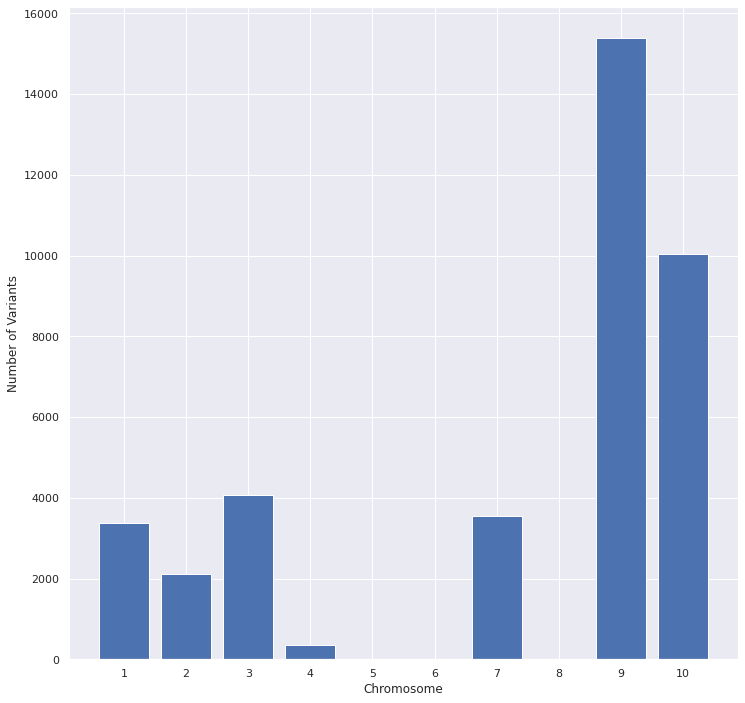

In [261]:
sns.set()
fig, ax = plt.subplots(figsize=(12,12))
ax = plt.bar(x=var_count['chromosome'],
             height=var_count['variant_id'],
             tick_label=var_count['chromosome'],)

plt.xlabel('Chromosome')
plt.ylabel('Number of Variants')
plt.show()

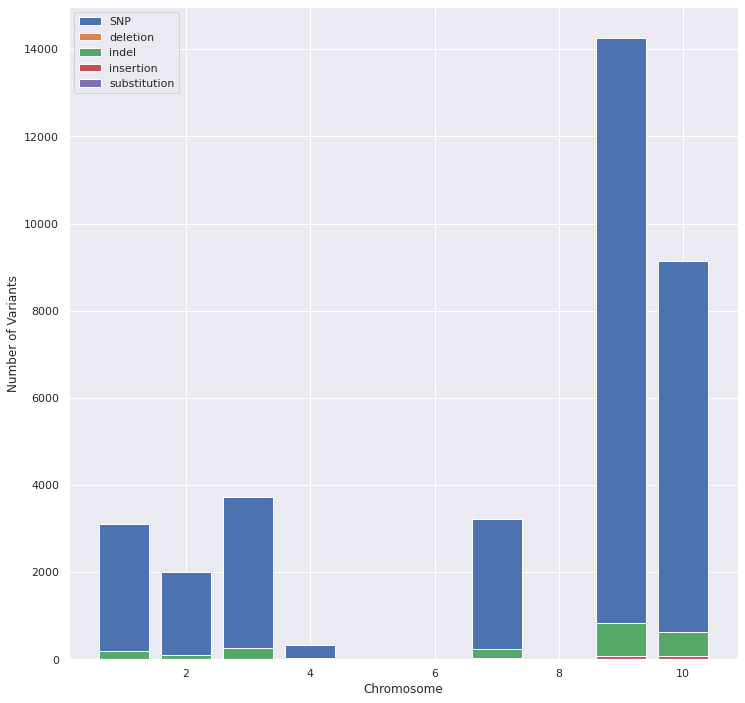

In [285]:
sns.set()
fig, ax = plt.subplots(figsize=(12,12))

for vclass in class_count['var_class'].unique():
    df = class_count[class_count['var_class']==vclass]
    ax.bar(
        x = df['chromosome'],
        height = df['variant_id'],
        label=vclass
    )


ax.set_xlabel('Chromosome')
ax.set_ylabel('Number of Variants')
ax.legend()
plt.show()

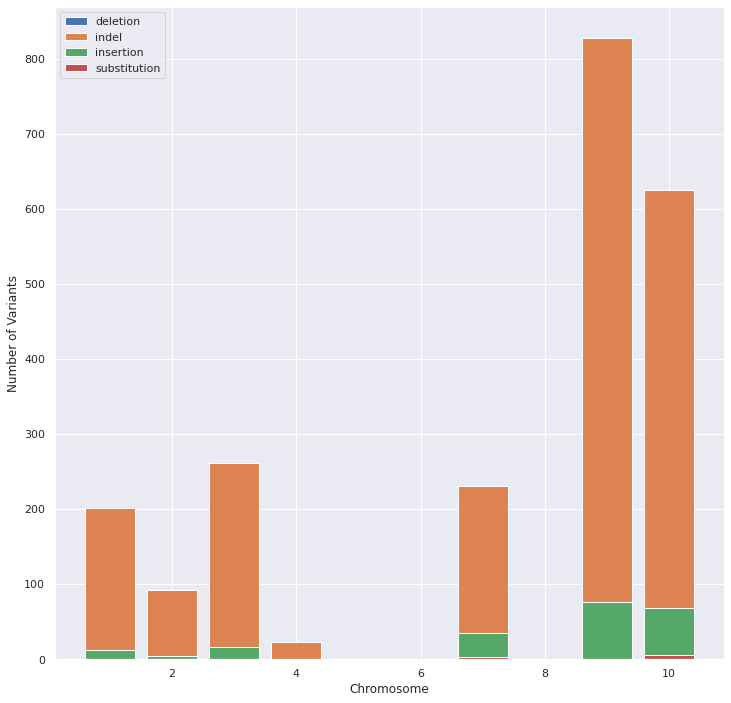

In [283]:
sns.set()
fig, ax = plt.subplots(figsize=(12,12))

for vclass in class_count['var_class'].unique():
    if vclass=="SNP":
        continue
    df = class_count[class_count['var_class']==vclass]
    ax.bar(
        x = df['chromosome'],
        height = df['variant_id'],
        label=vclass
    )


ax.set_xlabel('Chromosome')
ax.set_ylabel('Number of Variants')
ax.legend()
plt.show()